In [1]:
import os
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from pyHalo.preset_models import preset_model_from_name

from mejiro.galaxy_galaxy import SampleBELLS, SampleSL2S, SampleGG
from mejiro.instruments.roman import Roman
from mejiro.instruments.hwo import HWO
from mejiro.synthetic_image import SyntheticImage
from mejiro.utils import util

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [2]:
num_samples = 100

In [5]:
strong_lens = SampleGG()
log_main_halo_mass = 14  # np.log10(strong_lens.get_main_halo_mass())

In [6]:
CDM = preset_model_from_name('CDM')

cdm_realizations = []
for i in tqdm(range(num_samples)):
    cdm_realization = CDM(round(strong_lens.z_lens, 2), 
                          round(strong_lens.z_source, 2), 
                          cone_opening_angle_arcsec=5, 
                          log_m_host=log_main_halo_mass)
    cdm_realizations.append(cdm_realization)

# util.pickle('fig_1_data/cdm_realizations.pkl', cdm_realizations)

100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


In [7]:
WDM = preset_model_from_name('WDM')

wdm_7_realizations, wdm_8_realizations, wdm_9_realizations = [], [], []
for i in tqdm(range(num_samples)):
    wdm_7_realization = WDM(round(strong_lens.z_lens, 2), 
                            round(strong_lens.z_source, 2), 
                            log_mc=7, 
                            cone_opening_angle_arcsec=5, 
                            log_m_host=log_main_halo_mass)
    wdm_8_realization = WDM(round(strong_lens.z_lens, 2), 
                            round(strong_lens.z_source, 2), 
                            log_mc=8, 
                            cone_opening_angle_arcsec=5, 
                            log_m_host=log_main_halo_mass)
    wdm_9_realization = WDM(round(strong_lens.z_lens, 2), 
                            round(strong_lens.z_source, 2), 
                            log_mc=9, 
                            cone_opening_angle_arcsec=5, 
                            log_m_host=log_main_halo_mass)
    wdm_7_realizations.append(wdm_7_realization)
    wdm_8_realizations.append(wdm_8_realization)
    wdm_9_realizations.append(wdm_9_realization)

# util.pickle('fig_1_data/wdm_7_realizations.pkl', wdm_7_realizations)
# util.pickle('fig_1_data/wdm_8_realizations.pkl', wdm_8_realizations)
# util.pickle('fig_1_data/wdm_9_realizations.pkl', wdm_9_realizations)

100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


In [8]:
SIDM = preset_model_from_name('SIDM_core_collapse')

mass_ranges_subhalos = [[6.0, 7.0], [7.0, 8.0], [8.0, 9.0], [9.0, 10.0]]
mass_ranges_field_halos = [[6.0, 7.5], [7.5, 8.5], [8.5, 10.0]]
collapse_fraction_subhalos = [0.9, 0.7, 0.5, 0.2]
collapse_fraction_fieldhalos = [0.3, 0.2, 0.1]

sidm_realizations = []
for i in tqdm(range(num_samples)):
    sidm_realization = SIDM(round(strong_lens.z_lens, 2), 
                    round(strong_lens.z_source, 2), 
                    mass_ranges_subhalos, 
                    mass_ranges_field_halos, 
                    collapse_fraction_subhalos, 
                    collapse_fraction_fieldhalos, 
                    cone_opening_angle_arcsec=5, 
                    log_m_host=log_main_halo_mass)
    sidm_realizations.append(sidm_realization)

# strong_lens.add_realization(sidm_realization, use_jax=False)  # JAXtronomy doesn't support SPL_CORE profiles yet

# util.pickle('fig_1_data/sidm_realizations.pkl', sidm_realizations)

100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


In [9]:
ULDM = preset_model_from_name('ULDM')

uldm_realizations = []
for i in tqdm(range(num_samples)):
    uldm_realization = ULDM(round(strong_lens.z_lens, 2), 
                        round(strong_lens.z_source, 2), 
                        log10_m_uldm=-21,
                        cone_opening_angle_arcsec=5, 
                        log_m_host=log_main_halo_mass,
                        flucs_shape='ring',
                        flucs_args={'angle': 0.0, 'rmin': 0.9, 'rmax': 1.1},
                        log10_fluc_amplitude=-1.6, 
                        n_cut=1000000)
    uldm_realizations.append(uldm_realization)

# util.pickle('fig_1_data/uldm_realizations.pkl', uldm_realizations)

100%|██████████| 100/100 [09:54<00:00,  5.94s/it]


In [10]:
# cdm_realizations = util.unpickle('fig_1_data/cdm_realizations.pkl')
# wdm_7_realizations = util.unpickle('fig_1_data/wdm_7_realizations.pkl')
# wdm_8_realizations = util.unpickle('fig_1_data/wdm_8_realizations.pkl')
# wdm_9_realizations = util.unpickle('fig_1_data/wdm_9_realizations.pkl')
# sidm_realizations = util.unpickle('fig_1_data/sidm_realizations.pkl')
# uldm_realizations = util.unpickle('fig_1_data/uldm_realizations.pkl')

In [11]:
def get_bins_mean_std(realizations, num_bins):
    count_list = []

    for realization in realizations:
        cdm_halo_masses = [halo.mass for halo in realization.halos]
        count, bins = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, num_bins))
        count_list.append(count)

    return bins[:-1], np.mean(count_list, axis=0), np.std(count_list, axis=0)

bins = 20
bins_cdm_shmf, mean_cdm_shmf, std_cdm_shmf = get_bins_mean_std(cdm_realizations, bins)
bins_wdm_7_shmf, mean_wdm_7_shmf, std_wdm_7_shmf = get_bins_mean_std(wdm_7_realizations, bins)
bins_wdm_8_shmf, mean_wdm_8_shmf, std_wdm_8_shmf = get_bins_mean_std(wdm_8_realizations, bins)
bins_wdm_9_shmf, mean_wdm_9_shmf, std_wdm_9_shmf = get_bins_mean_std(wdm_9_realizations, bins)
bins_sidm_shmf, mean_sidm_shmf, std_sidm_shmf = get_bins_mean_std(sidm_realizations, bins)
bins_uldm_shmf, mean_uldm_shmf, std_uldm_shmf = get_bins_mean_std(uldm_realizations, bins)

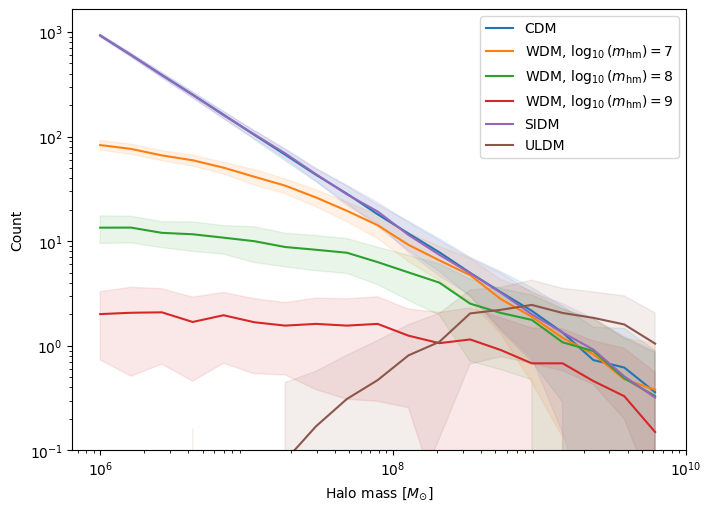

In [14]:
f, ax = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True)

std_alpha = 0.1
cdm_color = 'C0'
wdm_7_color = 'C1'
wdm_8_color = 'C2'
wdm_9_color = 'C3'
sidm_color = 'C4'
uldm_color = 'C5'

ax.loglog(bins_cdm_shmf, mean_cdm_shmf, 
          alpha=1., label=r'CDM', color=cdm_color)
ax.fill_between(bins_cdm_shmf, mean_cdm_shmf - std_cdm_shmf, mean_cdm_shmf + std_cdm_shmf, 
                alpha=std_alpha, color=cdm_color)

ax.loglog(bins_wdm_7_shmf, mean_wdm_7_shmf, 
          alpha=1., label=r'WDM, $\log_{10}(m_{\text{hm}})=7$', color=wdm_7_color)
ax.fill_between(bins_wdm_7_shmf, mean_wdm_7_shmf - std_wdm_7_shmf, mean_wdm_7_shmf + std_wdm_7_shmf,
                alpha=std_alpha, color=wdm_7_color)

ax.loglog(bins_wdm_8_shmf, mean_wdm_8_shmf, 
          alpha=1., label=r'WDM, $\log_{10}(m_{\text{hm}})=8$', color=wdm_8_color)
ax.fill_between(bins_wdm_8_shmf, mean_wdm_8_shmf - std_wdm_8_shmf, mean_wdm_8_shmf + std_wdm_8_shmf,
                alpha=std_alpha, color=wdm_8_color)

ax.loglog(bins_wdm_9_shmf, mean_wdm_9_shmf, 
          alpha=1., label=r'WDM, $\log_{10}(m_{\text{hm}})=9$', color=wdm_9_color)
ax.fill_between(bins_wdm_9_shmf, mean_wdm_9_shmf - std_wdm_9_shmf, mean_wdm_9_shmf + std_wdm_9_shmf,
                alpha=std_alpha, color=wdm_9_color)

ax.loglog(bins_sidm_shmf, mean_sidm_shmf, 
          alpha=1., label=r'SIDM', color=sidm_color)
ax.fill_between(bins_sidm_shmf, mean_sidm_shmf - std_sidm_shmf, mean_sidm_shmf + std_sidm_shmf, 
                alpha=std_alpha, color=sidm_color)

ax.loglog(bins_uldm_shmf, mean_uldm_shmf, 
          alpha=1., label=r'ULDM', color=uldm_color)
ax.fill_between(bins_uldm_shmf, mean_uldm_shmf - std_uldm_shmf, mean_uldm_shmf + std_uldm_shmf,
                alpha=std_alpha, color=uldm_color)

# ax.axvline(10**8.8, color='k', linestyle='--', linewidth=1, label='Euclid')
# ax.axvline(10**9, color='k', linestyle='--', linewidth=1, label='HST, Roman')

ax.set_xlabel('Halo mass [' + r'$M_{\odot}$]')
ax.set_xticks([1e6, 1e8, 1e10])
ax.set_ylabel('Count')

ax.set_ylim(bottom=1e-1)

plt.legend()
plt.savefig('/grad/bwedig/mejiro/projects/hwo/figures/fig_1.png', dpi=600)
plt.show()